# Regulated Forward Converter on UCx842/3/4/5

This design uses cheap and popular series of current-mode PWM controllers [UCx842 ... UCx845](http://www.ti.com/lit/ds/symlink/uc3845.pdf). The differences between them are summarized in the table below:

| Device                 | Startup voltage | Turn-off voltage (after startup) | Max duty cycle |
|------------------------|-----------------|----------------------------------|----------------|
| UC1842, UC2842, UC3842 | 16V             | 10V                              | 100%           |
| UC1843, UC2843, UC3843 | 8.4V            | 7.6V                             | 100%           |
| UC1844, UC2844, UC3844 | 16V             | 10V                              | 50%            |
| UC1845, UC2845, UC3845 | 8.4V            | 7.6V                             | 50%            |

UC184x and UC284x are usually manufactured for a wider range of operating temperatures than UC384x ICs. Normally UC844/5 are used for forward converters, since their duty cycle is limited to 50%. However by properly choosing the timing resistor, even UCx842 and UCx843 can be made to operate at duty cycles below 50% (please, do that with a generous safety margin and carefully test everything on the real circuit).

## Forward topology

A typical current-mode forward converter looks like this:

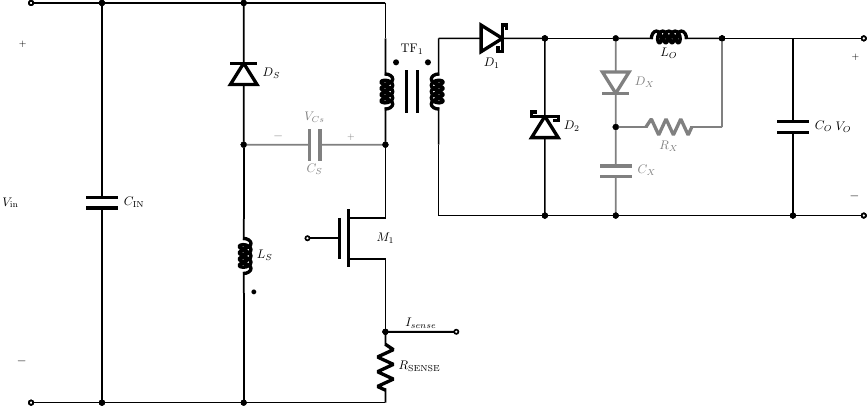

In [1]:
from IPython.display import display, Markdown, Image
import edcalc.schematics
display(Image(edcalc.schematics.forward_topology_image()))

It belongs to the same family of buck-derived converters as push-pull, half-bridge or full-bridge converters.
Fundamentally, it is just a buck converter with a transformer scaling the input voltage to a necessary level.
Which means, taking the scaling ratios into accout, you can ignore the transformer and pretend is just
a buck converter built around the inductor Lo. The output of the transformer is rectified by $D_1$ with $D_S$ and $D_2$
acting as freewheeling diodes dealing with magnetizing currents in reversed direction. Current-sensing resistor $R_{sense}$
can be replaced with a current transformer.

"non-canonical" parts

Capacitor $C_S$ is not present in the "canonical" forward topology, but together with the diode $D_S$ and the main switch
it allows to recover the energy stored in the primary leakage inductance and thus both eliminate the drain voltage spikes
and increase the converter efficiency. Reset winding $L_S$ is a part of the main transformer, wounded on the same core.

Another set of non-standard components are $C_X$, $D_X$ and $R_X$, together forming an optional RCD clamp, dealing with
the secondary leakage inductance voltage spikes, that can cause significant "ringing" and in the process destroy the output diodes
and/or cause raise the EMI levels. Connecting $R_X$ to the output instead of the ground helps to lower the power losses.

Some major pros and cons of the topology:

Pros:

* Being closest to a flyback in cost, can handle much higher power levels,
  alls without the need in an oversized and gapped transformer core.
  People even build [quite compact ARC welders](https://www.youtube.com/watch?v=82BbgB7nk8I)
  with this topology.
* Does not suffer from any flux imbalances in the transformer core.
* Relatively easy to build. In most cases doesn't require any specialized gate drivers.

Cons:

* The switch experiences theoretical voltage stress of at least $2 \times V_{in}$
  Normally the voltage stress is more than $2 \times V_{in}$ due to voltage
  spikes caused by the uncoupled leakage inductance of the transformer,
  unless dampened by a clamp or a snubber circuit.
  Such $2 \times V_{in}$ voltage stress makes forward converters less attractive for high input
  voltages such as european 240 VAC, requiring the use of expensive switches
  rated for 800-900V.
* Primary currents can also be quite significant, since one primary winding and switch carry
  the full load and we are limited by 45-50% duty cycle to guarantee full core reset each cycle.

## Design parameters

In [2]:
from edcalc.component_types import Core, MOSFET, Diode
from edcalc.smps import OutputParams
from edcalc.components import cores, diodes, switches

# Desired main switching frequency, Hz
# It may later be adjusted according to the real values of the capacitors/resistors of the oscillator,
# leading to a variable called 'F_sw'.
# It's a combined frequency of both switches, so each switch will turn on/off with a half of this frequency.
F_sw_desired = 100000

# Input voltage type: "AC" or "DC" 
V_in_type = "DC"
# Input voltage range (min, max)
V_in_range = (10, 13)



# Describe every output. The first one will be regulated
out = [
    OutputParams(V=20, I=12,
                 filter_core=cores['R33x17.8x11.1-MM52'], 
                 rectifier='half-wave',
                 D=diodes['SB10100'].parallel(2),
                 C=1000e-6, ESR=0.26, C_ripple=0.001),
]

# Expected efficiency
efficiency = 0.9
# Output inductor's ripple ratio (r = dI / I_L) in the worst conditions (when D = D_min)
# Must be less than 2 (to remain in CCM). Ideally, around 0.3-0.5
ripple = 0.4
# Desired duty cycle of a single switch at minimum input voltage.
# The actual value (calculated as 'D_max') will probably be slightly
# different depending on the components selected for the timing circuit.
D_max_desired = 0.35
# Input capacitor voltage ripple ratio dV/V
V_in_ripple = 0.05

### Magnetic elements ###
# The main transformer's core
core = cores['ETD44/22/15-N87']
# Current density, A/mm^2
I_density = 5
# Diameters of various wires available (to choose from), mm
wires_dia = [0.1, 0.25, 0.35, 0.45]
# Percentage the main transformer's uncoupled inductance,
# also known as leakage inductance. Typically it is 1-3% (0.01-0.03)
transformer_leakage_rate = 0.00241
# Peak flux density for the main transformer, Tesla
# 0.15T is far below a typical saturation density for most ferrites,
# but because in a forward converter ΔB is rather large (in comparison with flyback),
# a lower value helps to reduce losses
B_pk = 0.15

### About the main switch ###
switch = MOSFET(C_rss=935e-12, C_iss=10315e-12, R_ds=1.7e-3, Rt_JC=0.4, Rt_CA=61.6, T_j=175)  # IRLB3034
# switch = switches['IRF3205']
# Voltage driving the main switches (and powering the integrated driver if used), V
# depends on the voltage you power your controller with.
V_gs_sw = 12
# Max current driving the switches, A
I_drive_max = 0.8
#### Thermal design parameters ####
# Default ambient temperature, °C
T_ambient = 25
# Case-to-heatsink temperature resistance of the main switch (thermal paste), °C/W (set to None if not used)
Rt_CS_sw = 0.5
# Heatsink-to-ambient temperature resistance of the heatsink installed on the main switch, °C/W (set to None if not used)
Rt_SA_sw = 17
# Case-to-heatsink temperature resistance of the diodes (thermal paste), °C/W (set to None if not used)
Rt_CS_D = 0.5
# Heatsink-to-ambient temperature resistance of the diodes, °C/W (set to None if not used)
Rt_SA_D = 17


### Control circuit
controller_model = 'UCx843'
# Current tranformer core
current_sense_core = cores['PC21/13-USSR']

# Diodes used in for non-dissipative clamp (can be None)
ndclamp_diode = diodes['SS310']

In [3]:
import math
# Some convenient conversions
if V_in_type == 'AC':
    V_in_min = V_in_range[0] * math.sqrt(2)
    V_in_max = V_in_range[1] * math.sqrt(2)
else:
    V_in_min, V_in_max = V_in_range
P_out = [o.I * o.V for o in out]
P_out_sum = sum(P_out)
P_in = P_out_sum / efficiency

# Some safety checks
assert controller_model in ('UCx842', 'UCx843', 'UCx844', 'UCx845'), "Unsupported model of the controller"
assert D_max_desired < 0.5, "Duty cycle should not exceed 50%"
for o in out:
    assert o.rectifier == 'half-wave', "Only half-wave rectifier can be chosen for a forward converter"

In [4]:
from edcalc.format import (format_value, format_C, format_R, format_F, format_V, format_I,
                           format_L, format_W, block_of_values, format_flux_density,
                           warning_message, format_value_with_warning)
from edcalc.eseries import nearest_e12, nearest_e24, find_esum, find_precise_voltage_divider
from edcalc.smps import coil_selection

## Input-output

In [5]:
print(f'Input power (with {efficiency*100}% efficiency): {format_W(P_in)}')
print('Output power:', format_W(P_out_sum))

Input power (with 90.0% efficiency): 266.67W
Output power: 240.0W


## UC3846 oscillator

these calculations are based on [this datasheet on UC3846 from TI](http://www.ti.com/lit/ds/symlink/uc3846.pdf). By setting deadtime to be $ T_d = {1 - D_{max} \over F_{sw}} $ we can derive both time-setting resistor and capacitor.

In [6]:
class UC3843_RC:
    V_valley = 1.2
    V_peak = 2.8
    V_ref = 5
    I_disch = 8.3e-3
    
    @classmethod
    def rt(cls, D_max):
        """
        Calculates the value of the timing resistor Rt which determines maximum duty cycle.
        """
        B = (cls.V_valley - cls.V_ref) / (cls.V_peak - cls.V_ref)
        B1 = B**(1/D_max - 1)
        R_t = (cls.V_peak + cls.V_ref * (B1 - 1) - B1 * cls.V_valley) / (cls.I_disch * (B1 - 1))
        assert R_t > 542
        return R_t

    @classmethod
    def max_duty_cycle(cls, R_t):
        """
        Calculates the maximum duty cycle based on the value of the timing resistor.
        """
        assert R_t > 542
        block = (cls.V_valley - cls.V_ref) / (cls.V_peak - cls.V_ref)
        D_max = (
            math.log(block) /
            math.log(block * (R_t * cls.I_disch + cls.V_peak - cls.V_ref) /
                     (R_t * cls.I_disch + cls.V_valley - cls.V_ref)))
        return D_max

    @classmethod
    def ct(cls, F_sw, R_t):
        block = (cls.V_valley - cls.V_ref) / (cls.V_peak - cls.V_ref)
        return 1 / (R_t * F_sw * math.log(block * (R_t * cls.I_disch + cls.V_peak - cls.V_ref) /
                    (R_t * cls.I_disch + cls.V_valley - cls.V_ref)))
    
    @classmethod
    def freq(cls, R_t, C_t):
        block = (cls.V_valley - cls.V_ref) / (cls.V_peak - cls.V_ref)
        return 1 / (R_t * C_t * math.log(block * (R_t * cls.I_disch + cls.V_peak - cls.V_ref) /
                    (R_t * cls.I_disch + cls.V_valley - cls.V_ref)))

if controller_model in ('UCx844', 'UCx845'):
    # these controllers skip every other cycle to make sure duty cycle is limited to 50%,
    # so their oscillator should work at double the switching frequency
    R_osc = nearest_e24(UC3843_RC.rt(2 * D_max_desired))
    C_osc_target = UC3843_RC.ct(2 * F_sw_desired, R_osc)
    C_osc_parts = find_esum(C_osc_target)
    C_osc = sum(C_osc_parts)
    D_max = UC3843_RC.max_duty_cycle(R_osc) / 2
    F_sw = UC3843_RC.freq(R_osc, C_osc) / 2
else:
    # These controllers do not skip cycles
    R_osc = nearest_e24(UC3843_RC.rt(D_max_desired))
    C_osc_target = UC3843_RC.ct(F_sw_desired, R_osc)
    C_osc_parts = find_esum(C_osc_target)
    C_osc = sum(C_osc_parts)
    D_max = UC3843_RC.max_duty_cycle(R_osc)
    F_sw = UC3843_RC.freq(R_osc, C_osc)

display(block_of_values(
    ('Oscillator network R', format_R(R_osc)),
    ('Actual D_max is going to be', f'{round(D_max, 4)}'),
    ('Oscillator network C', ' || '.join(format_C(c) for c in C_osc_parts)),
    ('The actual frequency with the components selected', format_value(F_sw, 'Hz')),
))

<table><tr><td>Oscillator network R</td><td>560.0Ω</td></tr>
<tr><td>Actual D_max is going to be</td><td>0.3402</td></tr>
<tr><td>Oscillator network C</td><td>10.0nF || 1.2nF</td></tr>
<tr><td>The actual frequency with the components selected</td><td>99.23kHz</td></tr></table>

### Primary winding RMS and flat-topped peak currents

based on A. Pressman:
> Current drawn from the DC input source... has ... ramp-on-a-step waveshape...
> To simplify calculation, the pulses in the figure are
> assumed to have an equivalent flat-topped waveshape whose amplitude
> $I_{pft}$ is the value of the current at the center of the ramp.

In [7]:
I_pft = P_out_sum / (efficiency * V_in_min * D_max)
I_pri_rms = I_pft * math.sqrt(D_max)

display(block_of_values(
    (f'Flat-topped peak current of the primary winding', format_I(I_pft)),
    (f'RMS current of the primary winding', format_I(I_pri_rms)),
))

<table><tr><td>Flat-topped peak current of the primary winding</td><td>78.39A</td></tr>
<tr><td>RMS current of the primary winding</td><td>45.72A</td></tr></table>

## The main transformer

In [8]:
# In theory, we can use V_in_min while calculating the number of primary turns at D_max.
# However there is a possibility that during the startup time the converter
# will fail to adjust its duty cycle quickly enough to avoid saturation.
# So we're planning for the worst case scenario, which is V_in_max at D_max.
N_p = math.ceil(V_in_max * D_max / (F_sw * B_pk * core.A_e_mks))
L_p = core.A_L_mks * N_p**2
secondary_turns = [math.ceil(N_p * (o.V/D_max + o.full_diode_drop()) / (V_in_min - I_pft * switch.R_ds)) for o in out]
L_secondary = [core.A_L_mks * ns**2 for ns in secondary_turns]
turns_ratios = [N_p / t for t in secondary_turns]
D_min = (out[0].V + out[0].full_diode_drop()) * turns_ratios[0] / V_in_max
dB_pk = V_in_max * D_max / (F_sw * N_p * core.A_e_mks)
display(block_of_values(
    ('Minimum duty cycle $D_{min}$', f'{round(D_min, 2)}'),
    ('Maximum possible flux density at $V_{inMAX}$ (assuming $D_{max}$ is limited by the timing circuit!)', format_flux_density(dB_pk, core.B_sat)),
))

<table><tr><td>Minimum duty cycle $D_{min}$</td><td>0.25</td></tr>
<tr><td>Maximum possible flux density at $V_{inMAX}$ (assuming $D_{max}$ is limited by the timing circuit!)</td><td>128.79mT, which is OK</td></tr></table>

In [9]:
display(Markdown(f"\n### Primary and reset windings (each {N_p} turns, {format_L(L_p)})\n"))
display(coil_selection(F_sw, I_pri_rms, wires_dia, I_density, N_p, winding_area=core.W_a))

for i, o in enumerate(out):
    display(Markdown(f"\n### Secondary winding #{i + 1} ({'2 X ' if o.is_center_tapped else ''}"
          f"{secondary_turns[i]} turns, {format_L(L_secondary[i])})\n"))
    display(coil_selection(F_sw, out[i].I, wires_dia, I_density, secondary_turns[i], winding_area=core.W_a))


### Primary and reset windings (each 2 turns, 14.0uH)


With the RMS current of 45.72A and max current density of 5 $A/mm^2$, we need at least 9.14 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.42 $ mm $ (0.14 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 2 turns occupy |
|-----------|-----------|----------------|---------|---------------|----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 1165    | 9.1499 $mm^2$ | 28%            |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 187     | 9.1793 $mm^2$ | 28%            |
| 0.35 $mm$ | 0.35 $mm$ | OK             | 96      | 9.2363 $mm^2$ | 28%            |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 58      | 9.1826 $mm^2$ | 28%            |


### Secondary winding #1 (13 turns, 591.5uH)


With the RMS current of 12.0A and max current density of 5 $A/mm^2$, we need at least 2.4 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.42 $ mm $ (0.14 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 13 turns occupy |
|-----------|-----------|----------------|---------|---------------|-----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 306     | 2.4033 $mm^2$ | 48%             |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 49      | 2.4053 $mm^2$ | 48%             |
| 0.35 $mm$ | 0.35 $mm$ | OK             | 25      | 2.4053 $mm^2$ | 48%             |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 16      | 2.5331 $mm^2$ | 51%             |

## DC input capacitor

In [10]:
C_in = nearest_e12(I_pft * D_max / (F_sw * V_in_min * V_in_ripple), 'higher')
ESR_C_in = V_in_min * V_in_ripple / I_pft
display(block_of_values(
    ('Minimum recommended input capacitor', format_C(C_in)),
    ('Recommended ESR', format_R(ESR_C_in)),
    ('Minimum voltage rating of the capacitor', format_V(1.2 * V_in_max))
))

<table><tr><td>Minimum recommended input capacitor</td><td>560.0uF</td></tr>
<tr><td>Recommended ESR</td><td>6.38mΩ</td></tr>
<tr><td>Minimum voltage rating of the capacitor</td><td>15.6V</td></tr></table>

## Non-dissipative clamping and recovery with the reset winding

Each time the switches stops conducting, a huge voltage spike occurs at its drain. This is due to the leakage (uncoupled) inductance of the main transformer, which tries to keep the current flowing and thus raises the voltage across its ends. Left ignored, such spikes can destroy the switch.

["Nondissipative Clamping Benefits DC-DC Converters" by By Viktor D. Vogman](https://www.powerelectronics.com/content/article/21857520/nondissipative-clamping-benefits-dcdc-converters) ([pdf version](static/papers/non-dissipative-clamping.pdf)) describes an effective method of clamping those spikes and recovering their energy.

In [11]:
clamp2_components, clamp2_info = edcalc.smps.non_dissipative_coupled_clamp(
    V_in_min, V_in_max, I_pri_pk=I_pft, L_leakage=L_p * transformer_leakage_rate, T_clamp_on=D_min/F_sw, T_clamp_off=(2 - D_min) / F_sw, V_ripple=0.01)
display(block_of_values(*clamp2_info))

if ndclamp_diode is not None:
    display(Markdown('#### Working conditions of the diode'))
    display(block_of_values(
        *ndclamp_diode.check_conditions(
            V_max=clamp2_components.V_D,
            I_pk=clamp2_components.I_D_pk,
            I_avg=clamp2_components.I_D_avg),
        *ndclamp_diode.thermal_analysis(clamp2_components.I_D_avg, Rt_CS=Rt_CS_D, Rt_SA=Rt_SA_D)
    ))

<table><tr><td>Minimum $C_S$</td><td>110.0uF</td></tr>
<tr><td>RMS current of the recovery winding</td><td>12.89A</td></tr>
<tr><td>Resonant frequency (must be $<< F_{sw}$)</td><td>3.03uHz</td></tr>
<tr><td>Max drain-source voltage:</td><td>26.0V</td></tr>
<tr><td>$D_S$ reverse voltage</td><td>26.0V</td></tr>
<tr><td>$D_S$ peak current</td><td>78.39A</td></tr>
<tr><td>$D_S$ RMS current</td><td>5.47A</td></tr>
<tr><td>$D_S$ average current</td><td>571.55mA</td></tr></table>

#### Working conditions of the diode

<table><tr><td>Diodes connected in parallel</td><td>1</td></tr>
<tr><td>Max reverse voltage on each of the diodes</td><td>26.0V, which is OK</td></tr>
<tr><td>Peak current through each diode</td><td>78.39A, which is OK</td></tr>
<tr><td>Average current per diode</td><td>571.55mA, which is OK</td></tr>
<tr><td>Power being dissipated, per component</td><td>485.82mW</td></tr>
<tr><td>Junction temperature without a heatsink</td><td>61.44°C, which is OK</td></tr>
<tr><td>Junction temperature with the heatsink</td><td>43.22°C, which is OK</td></tr></table>

## Main switches

In [12]:
# Thermal analysis
T_rise = switch.gate_drive_charge(V_in_max, V_gs_sw) / I_drive_max
R_gate_sw = V_gs_sw / I_drive_max

display(block_of_values(
    *switch.thermal_analysis(I_pri_rms, Rt_CS_sw, Rt_SA_sw),
    (f'Gate resistors:', format_R(R_gate_sw)),
    (f'Rise time', format_value(T_rise, 's')),
    ('Max drain-source voltage:', 'depends on the clamp/snubber chosen'),
    (f'RMS current', format_I(I_pri_rms)),
    (f'Peak current', format_I(I_pft)),
    (f'Switching losses', format_W(switch.gate_drive_charge(V_in_max, V_gs_sw) * V_gs_sw * F_sw/2))
))

<table><tr><td>Power being dissipated, per component</td><td>3.55W</td></tr>
<tr><td>Junction temperature without a heatsink</td><td>245.34°C <span style="font-weight:bold; color: #ff0000;">WARNING:</span> <span style="font-weight:bold;">Too hot (>= 175.0°C)!</span></td></tr>
<tr><td>Junction temperature with the heatsink</td><td>88.61°C, which is OK</td></tr>
<tr><td>Gate resistors:</td><td>15.0Ω</td></tr>
<tr><td>Rise time</td><td>169.92ns</td></tr>
<tr><td>Max drain-source voltage:</td><td>depends on the clamp/snubber chosen</td></tr>
<tr><td>RMS current</td><td>45.72A</td></tr>
<tr><td>Peak current</td><td>78.39A</td></tr>
<tr><td>Switching losses</td><td>80.94mW</td></tr></table>

## Output filters

Please, note that according to A. Pressman:

> The output capacitor Co is selected to meet the maximum output ripple
voltage specification. In Section 1.3.7 it was shown that the output
ripple is determined almost completely by the magnitude of the ESR
(equivalent series resistance, Ro ) in the filter capacitor and not by the
magnitude of the capacitor itself.

The theory is covered in ["Understanding Buck Power Stages"](static/papers/slva057-buck-power-stages.pdf)
by Everett Rogers
and in [Analog Circuit Design Volume 2: Immersion in the Black Art of Analog Design](https://books.google.ru/books?id=H9rAU4Rf--YC&lpg=PA108&pg=PA108#v=onepage&q&f=false)
by Bob Dobkin and Jim Williams.

In [13]:
out_info, L_out, C_out, ESR_C_out = [], [], [], []
for i, o in enumerate(out):
    display(Markdown(f'\n###  Output #{i+1}: ###\n'))
    V_s_in_min = V_in_min / turns_ratios[i] - o.full_diode_drop()
    V_s_in_max = V_in_max / turns_ratios[i] - o.full_diode_drop()
    output_suggestions, extra_info = edcalc.smps.buck_output_params(
        F_sw, V_s_in_min, V_s_in_max, D_min, D_max, o.V, o.I, ripple, o.filter_core, o.C_ripple)
    display(block_of_values(*extra_info))
    display(Markdown('### The winding'))
    display(coil_selection(F_sw, o.I, wires_dia, I_density, output_suggestions.N))
    out_info.append(output_suggestions)
    L_out.append(output_suggestions.L)
    C_out.append(output_suggestions.C if o.C is None else o.C)
    ESR_C_out.append(output_suggestions.ESR if o.ESR is None else o.ESR)


###  Output #1: ###


<table><tr><td>Output voltage</td><td>20.0V</td></tr>
<tr><td>Output current</td><td>12.0A</td></tr>
<tr><td>Output voltage ripple (0.1%)</td><td>20.0mV</td></tr>
<tr><td>Output inductor</td><td>34.3uH, 19 turns</td></tr>
<tr><td>Inductor mode</td><td>continuous</td></tr>
<tr><td>Inductor's peak flux density</td><td>889.92mT, which is OK</td></tr>
<tr><td>Inductor's peak current:</td><td>39.69A</td></tr>
<tr><td>$r = \Delta I / I_L$ at $V_{inmin}$</td><td>0.37</td></tr>
<tr><td>$r = \Delta I / I_L$ at $V_{inmax}$</td><td>0.38</td></tr>
<tr><td>Recommended minimum capacitor:</td><td>290.65uF</td></tr>
<tr><td>Max ESR of this capacitor should be</td><td>4.33mΩ</td></tr>
<tr><td>Output capacitor RMS current</td><td>1.33A</td></tr>
<tr><td>Such capacitor will dissipate</td><td>7.69mW</td></tr></table>

### The winding

With the RMS current of 12.0A and max current density of 5 $A/mm^2$, we need at least 2.4 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.42 $ mm $ (0.14 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 19 turns occupy |
|-----------|-----------|----------------|---------|---------------|-----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 306     | 2.4033 $mm^2$ |                 |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 49      | 2.4053 $mm^2$ |                 |
| 0.35 $mm$ | 0.35 $mm$ | OK             | 25      | 2.4053 $mm^2$ |                 |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 16      | 2.5331 $mm^2$ |                 |

## Output rectifiers

**WARNING**: Please, note that the maximum voltage here assumes 100% ideal transformer. The real voltage might be about 30% higher due to the ringing caused by the leakage inductance.

In [14]:
for i, o in enumerate(out):
    if o.rectifier is None:
        continue
    display(Markdown(f'\n### Output #{i + 1} ({o.rectifier} rectifier) ###'))
    _I_D_avg = o.diode_average_current(
        # at any moment one of the two diodes is conducting
        # (either the rectifying or the freewheeling one)
        D=max(D_max, 1-D_min))
    display(block_of_values(
        *o.D.check_conditions(
            V_max=o.diode_reverse_voltage(V_in_max / turns_ratios[i]),
            I_avg=_I_D_avg,
            I_pk=o.I * (1 + out_info[i].max_ripple / 2)),
        *o.D.thermal_analysis(
            _I_D_avg,
            T_ambient=T_ambient, Rt_CS=Rt_CS_D, Rt_SA=Rt_SA_D)
    ))


### Output #1 (half-wave rectifier) ###

<table><tr><td>Diodes connected in parallel</td><td>2</td></tr>
<tr><td>Max reverse voltage on each of the diodes</td><td>83.65V, which is OK</td></tr>
<tr><td>Peak current through each diode</td><td>7.15A, which is OK</td></tr>
<tr><td>Average current per diode</td><td>4.52A, which is OK</td></tr>
<tr><td>Power being dissipated, per component</td><td>3.84W</td></tr>
<tr><td>Junction temperature without a heatsink</td><td>190.19°C <span style="font-weight:bold; color: #ff0000;">WARNING:</span> <span style="font-weight:bold;">Too hot (>= 150.0°C)!</span></td></tr>
<tr><td>Junction temperature with the heatsink</td><td>99.91°C, which is OK</td></tr></table>

## Output RCD clamps

These clamps come into playing only when the cathode voltage of the diodes raises to a certain threshold above $V_{IN} \times N_s/N_p$. This threshold is defined by the `burn_ratio` parameter of the clamp (5% by default), telling how much leakage inductance's energy must be turned into heat each cycle. Because energy stored in the capacitor is proportional to the square of its voltage, even if we burn out only a small part of the energy of the leakage inductance, this already substantially drops the voltage.

In [15]:
for i, o in enumerate(out):
    display(Markdown(f'### Output #{i + 1} RCD clamp'))
    rclamp_components, rclamp_info = edcalc.smps.buck_rectifier_clamp(
        L_leakage=L_secondary[i] * transformer_leakage_rate,
        I_pk=o.I * (1 + out_info[i].max_ripple/2),
        V_in_max=V_in_max / turns_ratios[i],
        V_ripple=0.01, V_out=out[i].V, F_sw=F_sw)
    display(block_of_values(*rclamp_info))

### Output #1 RCD clamp

<table><tr><td>Leakage energy burn ratio</td><td>5.0%</td></tr>
<tr><td>Pre-inductor voltage will be clamped at</td><td>87.09V</td></tr>
<tr><td>Minimum clamp capacitor $C_X$</td><td>2.2uF</td></tr>
<tr><td>Maximum voltage at $C_X$</td><td>86.09V</td></tr>
<tr><td>Clamp resistor $R_X$</td><td>5.6kΩ</td></tr>
<tr><td>Maximum $R_X$ current</td><td>11.8mA</td></tr>
<tr><td>Power dissipated on $R_X$</td><td>780.09mW</td></tr>
<tr><td>Peak current through $D_X$</td><td>14.31A</td></tr>
<tr><td>Average current through $D_X$</td><td>168.17mA</td></tr></table>

## Current sensing circuit

UCx8425 series isn't well suited for measuring large currents using resistors, because its current-limiting voltage is 1V (unless error amplifier's output is clamped). This requires the use of quite large values of bulky high-power sensing resistors. So here, instead, a current sense transformer is used.

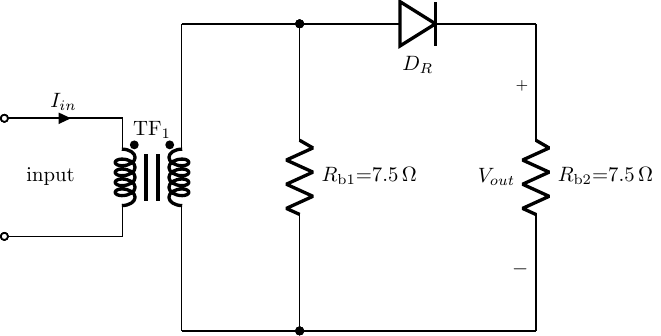

<table><tr><td>Primary winding turns</td><td>1</td></tr>
<tr><td>Secondary winding turns</td><td>200</td></tr>
<tr><td>Primary side inductance</td><td>100.0nH</td></tr>
<tr><td>Secondary side inductance</td><td>4.0mH</td></tr>
<tr><td>First and second burden resistors</td><td>7.5Ω</td></tr>
<tr><td>Power dissipated by each resistor</td><td>100.0mW</td></tr>
<tr><td>Peak magnetic flux</td><td>135.86mT, which is OK</td></tr>
<tr><td>Peak input current</td><td>78.39A</td></tr>
<tr><td>Peak output voltage</td><td>1.0V</td></tr>
<tr><td>Output voltage matching RMS current</td><td>357.28mV</td></tr>
<tr><td>Max voltage the diodes should be able to withstand</td><td>2.94V</td></tr></table>

In [16]:
current_transformer_network = edcalc.smps.CurrentTransformerNetwork.create(I_pft, 1, I_pri_rms, current_sense_core, secondary_turns=200, rectifier='half-wave')
current_transformer_network.draw()
display(current_transformer_network.markdown())

## Feedback loop control (non-isolated)

This form utilizes UC3846's own error amplifier to regulate the output voltage. It's cheap, but unless the controller is fully isolated from the MOSFETs and the input, this method can be used only for non-isolated DC-DC converters.


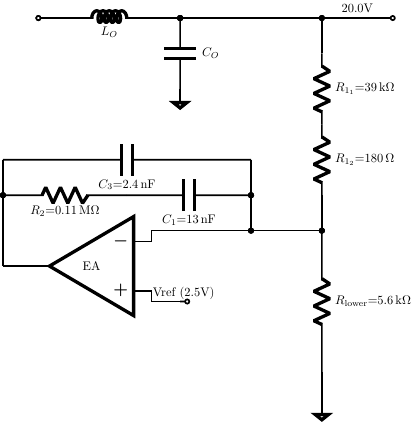

In [17]:
feedback = edcalc.smps.CurrentModeFeedback.buck(
    F_sw, 1/I_pft, D_min, D_max, out[0].V, out[0].I, L_out[0], C_out[0], ESR_C_out[0], 2.5, turns_ratios[0])
feedback.draw_circuit()